# 画图：观察攻击模型对噪声的适应性

In [1]:
import pandas as pd
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("stupidtree/[EXP]BiSR_diff_noise_gaussian")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })


In [2]:
filtered = []

for summary, config, name in zip(summary_list, config_list, name_list):
    if config['dataset'] == 'piqa':
        filtered.append((summary, config, name))

In [3]:
sfl_noise_scales = set()

for summary, config, name in filtered:
    sfl_noise_scales.add(config['noise_scale_gaussian'])

In [4]:
sfl_noise_scales.remove(0.25)
sfl_noise_scales.remove(0.4)

In [5]:
result_map = {}
for sfl_noise_scale in sfl_noise_scales:
    if sfl_noise_scale == 0.05:
        continue
    attack_performs = {}
    ppl_avg = 0
    tag_avg = 0
    case_num = 0
    for summary, config, name in filtered:
        if config['noise_scale_gaussian'] == sfl_noise_scale:
            model_name = config['attacker_model']
            if model_name == 'gru':
                model_name = 'GRU'
            elif model_name == 'moe':
                model_name = 'NaMoE'
            attack_performs[f'SDRP-only({model_name})'] = summary['client0_DRA_b2tr_rgLf_avg']
            attack_performs[f'BiSR({model_name})'] = summary['client0_DLG_rgL_f_avg']
            ppl_avg += summary['client0_test-ppl']
            tag_avg += summary['client0_DLG_raw_rgLf_avg']
            case_num += 1
    attack_performs['PPL'] = ppl_avg / case_num
    attack_performs['TAG'] = tag_avg / case_num
    result_map[sfl_noise_scale] = attack_performs


result_map

{2: {'SDRP-only(GRU)': 0.8069862452314503,
  'BiSR(GRU)': 0.9371450737869406,
  'SDRP-only(NaMoE)': 0.8298784902107156,
  'BiSR(NaMoE)': 0.9294178227707852,
  'PPL': 27.524629592895508,
  'TAG': 0.5858869129664778},
 0.3: {'SDRP-only(GRU)': 0.10391473127771676,
  'BiSR(GRU)': 0.4660690275113115,
  'SDRP-only(NaMoE)': 0.24066706804931337,
  'BiSR(NaMoE)': 0.5674909987015859,
  'PPL': 98.53534317016602,
  'TAG': 0.579664797658573},
 1.75: {'SDRP-only(GRU)': 0.7741777042864902,
  'BiSR(GRU)': 0.9364530637566514,
  'SDRP-only(NaMoE)': 0.8277821300750833,
  'BiSR(NaMoE)': 0.9267715376212,
  'PPL': 25.755258560180664,
  'TAG': 0.5838796530506027},
 1.5: {'SDRP-only(GRU)': 0.730848190333862,
  'BiSR(GRU)': 0.9366628793381604,
  'SDRP-only(NaMoE)': 0.8145728350672657,
  'BiSR(NaMoE)': 0.915819904208114,
  'PPL': 22.261842727661133,
  'TAG': 0.5860314142614851},
 1.25: {'SDRP-only(GRU)': 0.6309714635333482,
  'BiSR(GRU)': 0.9157172056402664,
  'SDRP-only(NaMoE)': 0.78925134934735,
  'BiSR(NaMoE

In [6]:
# rearrange the result

all_data = {}
for key in list(result_map.values())[0].keys():
    all_data[key] = {}
    for sfl_noise_scale, attack_performs in result_map.items():
        all_data[key][sfl_noise_scale] = attack_performs[key]


In [7]:
all_data

{'SDRP-only(GRU)': {2: 0.8069862452314503,
  0.3: 0.10391473127771676,
  1.75: 0.7741777042864902,
  1.5: 0.730848190333862,
  1.25: 0.6309714635333482,
  1: 0.5299114878721263,
  0.75: 0.39101064765779553,
  0.5: 0.24101559757721844},
 'BiSR(GRU)': {2: 0.9371450737869406,
  0.3: 0.4660690275113115,
  1.75: 0.9364530637566514,
  1.5: 0.9366628793381604,
  1.25: 0.9157172056402664,
  1: 0.8920929421451831,
  0.75: 0.8008527915472414,
  0.5: 0.6179763231413912},
 'SDRP-only(NaMoE)': {2: 0.8298784902107156,
  0.3: 0.24066706804931337,
  1.75: 0.8277821300750833,
  1.5: 0.8145728350672657,
  1.25: 0.78925134934735,
  1: 0.76618145089567,
  0.75: 0.6984909542143126,
  0.5: 0.5260640888290772},
 'BiSR(NaMoE)': {2: 0.9294178227707852,
  0.3: 0.5674909987015859,
  1.75: 0.9267715376212,
  1.5: 0.915819904208114,
  1.25: 0.9177434930940152,
  1: 0.9074548451799028,
  0.75: 0.869212371331198,
  0.5: 0.7691287350861642},
 'PPL': {2: 27.524629592895508,
  0.3: 98.53534317016602,
  1.75: 25.7552585

/tmp/ipykernel_401182/2351617798.py:99: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles2, labels2 = ax2.get_legend_handles_labels()


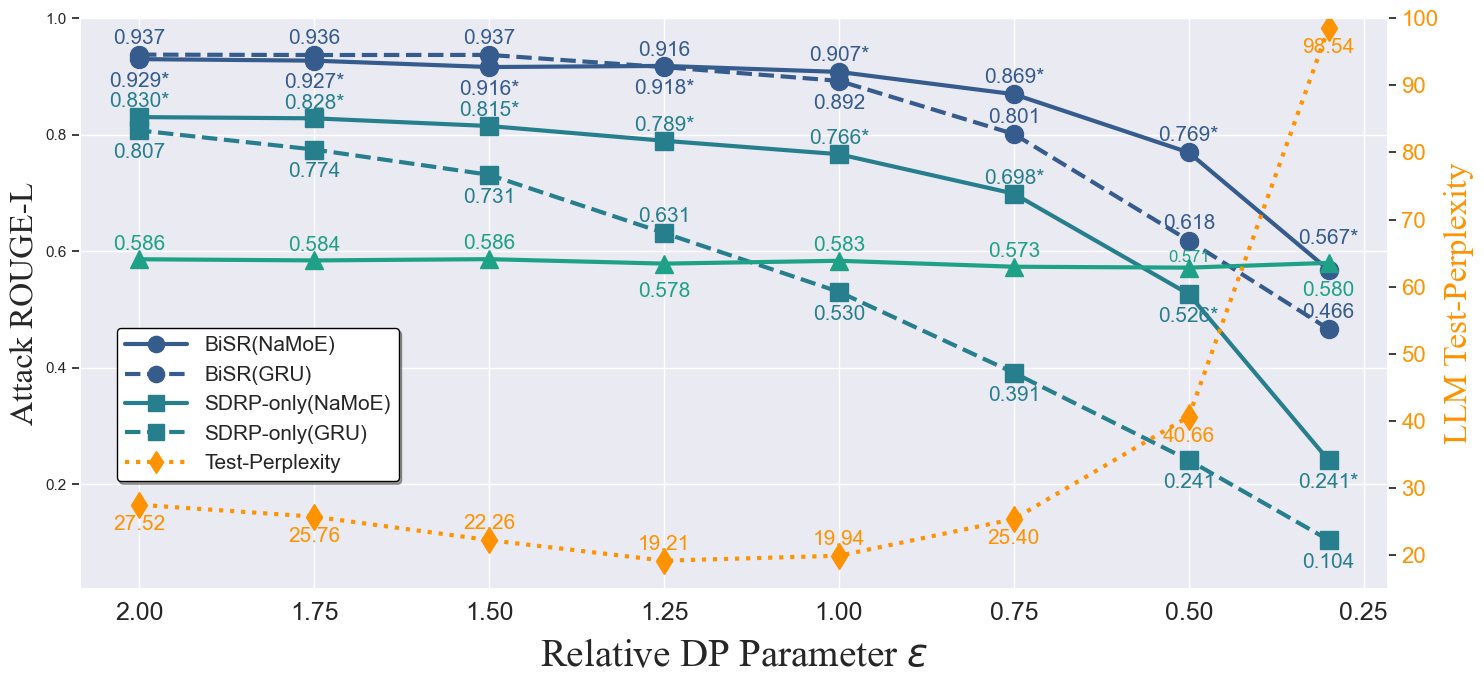

In [25]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()

# create line figure with two y axis, one for ppl and one for rouge
fig, ax1 = plt.subplots(figsize=(15, 7))
# plot rouge

ax2 = ax1.twinx()
all_data = dict(sorted(all_data.items(), key=lambda x: x[0]))

atk_colors = sns.color_palette("viridis", 6)[1:]
color_ppl = sns.color_palette("autumn", 6)[3]

for key, attack_performs in all_data.items():
    ns = sorted(attack_performs.keys())
    ps = [attack_performs[n] for n in ns]
    if key == 'PPL':
        ax2.plot(ns, ps, markersize=13, color=color_ppl, marker='d', linestyle=':', label='Test-Perplexity',linewidth=3)
        # plit text on top of the line
        for n, txt in zip(ns,ps):
            pos = -18
            if n == 1.25 or n == 1 or n == 1.5:
                pos = 8
            ax2.annotate(f'{txt:.2f}', (n,txt), textcoords="offset points", xytext=(0, pos),
                         ha='center', fontsize=15, color=color_ppl, label='Test-Perplexity')
    else:
        marker = 'o'
        color = atk_colors[0]
        if 'SDRP' in key:
            marker = 's'
            color = atk_colors[1]
        elif 'TAG' in key:
            marker = '^'
            color = atk_colors[2]
        if 'GRU' in key:
            line_style = '--'
        else:
            line_style = '-'
        ax1.plot(ns, ps, marker=marker, markersize=13, label=key, color=color, linestyle=line_style,linewidth=3)
        if key == 'BiSR(NaMoE)':
            # plot text on top of the line
            for n, txt in zip(ns,ps):
                pos = 8
                if n >= 1.25:
                    pos = -20
                elif n == 0.3:
                    pos = 19
                ax1.annotate(f'{txt:.3f}*', (n, txt), textcoords="offset points", xytext=(0, pos),
                             ha='center', fontsize=15, color=color)
        elif key =='BiSR(GRU)':
            # plot text on top of the line
            for n, txt in zip(ns,ps):
                pos = 8
                if  n == 1:
                    pos = -20
                ax1.annotate(f'{txt:.3f}', (n, txt), textcoords="offset points", xytext=(0, pos),
                             ha='center', fontsize=15, color=color)
        elif key == 'TAG':
            for n,txt in zip(ns,ps):
                pos = 7
                fontsize = 15
                if n == 1.25 or n == 0.3:
                    pos = -24
                if n == 0.5:
                    fontsize = 12
                    pos = 4
                ax1.annotate(f'{txt:.3f}', (n, txt), textcoords="offset points", xytext=(0, pos),
                             ha='center', fontsize=fontsize, color=color)
        elif key == 'SDRP-only(GRU)':
            # plot text on top of the line
            for i, txt in enumerate(ps):
                pos = -20 if i != 4 else 8
                ax1.annotate(f'{txt:.3f}', (list(ns)[i], list(ps)[i]), textcoords="offset points", xytext=(0, pos),
                             ha='center', fontsize=15, color=color)
        elif key == 'SDRP-only(NaMoE)':
            # plot text on top of the line
            for i, txt in enumerate(ps):
                pos = -20 if i < 2 else 7
                ax1.annotate(f'{txt:.3f}*', (list(ns)[i], list(ps)[i]), textcoords="offset points", xytext=(0, pos),
                             ha='center', fontsize=15, color=color)

ax1.set_ylim(0.02, 1.0)

ax1.set_ylabel('Attack ROUGE-L', fontsize=24,fontname="Times New Roman")
ax2.set_ylabel('LLM Test-Perplexity', fontsize=24, fontname="Times New Roman", color=color_ppl)
ax2.tick_params(axis='y', labelcolor=color_ppl, labelsize=16)
ax1.set_xlabel('Relative DP Parameter $\epsilon$', fontsize=28, fontname="Times New Roman", labelpad=10)
ax1.tick_params(axis='x', labelsize=18)
ax2.set_ylim(15, 100)
# set legend
# fig.legend(ncol=2, fontsize=14)
# reorder the legend
handles, labels = ax1.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[3], handles[2]]
labels = [labels[1], labels[0], labels[3], labels[2]]
handles2, labels2 = ax2.get_legend_handles_labels()
handles.extend(handles2)
labels.extend(labels2)

# plt.legend(handles, labels, fontsize=12, ncol=1, loc='lower left', bbox_to_anchor=(0.02, 0.16),
#            markerscale=0.9, handlelength=3.0)
plt.legend(handles, labels, fontsize=15, ncol=1, loc='lower left', bbox_to_anchor=(0.02, 0.17),
           markerscale=0.9, handlelength=3.0, frameon=True, fancybox=True, shadow=True, framealpha=1, edgecolor='black',
           facecolor='white')

ax2.yaxis.grid(False)
# reverse the x axis
plt.gca().invert_xaxis()
# save the figure
plt.tight_layout()
plt.savefig('/root/autodl-tmp/sfl/exp_data/diff_noise_gaussian.pdf')